In [1]:
%autosave 90

Autosaving every 90 seconds


Name: Jishnu Chander Ravichanderan <br>
Github Username: jishnuchander <br>
USC ID: 1144843551 <br>

In [260]:
# Importing all required libraries
import os
import re
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt
from math import floor as fl
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D

### (b) Data Exploration and Pre-processing
i. You can use binary encoding for the sentiments , i.e y = 1 for positive senti-
ments and y = -1 for negative sentiments.

In [30]:
path = os.getcwd()+"\Data\\neg"

num = []
text = []
for file in os.listdir(path):
    with open(os.path.join(path, file), 'r') as f:
        text.append(f.read())
    num.append(file[2:5])

In [39]:
df_neg = pd.DataFrame(zip(text, num), columns=['review', 'review_num'])
df_neg['label'] = -1
df_neg

,review,review_num,label
0,"plot : two teen couples go to a church party ,...",000,-1
1,the happy bastard's quick movie review \ndamn ...,001,-1
2,it is movies like these that make a jaded movi...,002,-1
3,""" quest for camelot "" is warner bros . ' firs...",003,-1
4,synopsis : a mentally unstable man undergoing ...,004,-1
...,...,...,...
995,"if anything , "" stigmata "" should be taken as ...",995,-1
996,"john boorman's "" zardoz "" is a goofy cinematic...",996,-1
997,the kids in the hall are an acquired taste . \...,997,-1
998,there was a time when john carpenter was a gre...,998,-1


In [40]:
path = os.getcwd()+"\Data\\pos"

num = []
text = []
for file in os.listdir(path):
    with open(os.path.join(path, file), 'r') as f:
        text.append(f.read())
    num.append(file[2:5])

In [42]:
df_pos = pd.DataFrame(zip(text, num), columns=['review', 'review_num'])
df_pos['label'] = 1
df_pos

,review,review_num,label
0,films adapted from comic books have had plenty...,000,1
1,every now and then a movie comes along from a ...,001,1
2,you've got mail works alot better than it dese...,002,1
3,""" jaws "" is a rare film that grabs your atten...",003,1
4,moviemaking is a lot like being the general ma...,004,1
...,...,...,...
995,wow ! what a movie . \nit's everything a movie...,995,1
996,"richard gere can be a commanding actor , but h...",996,1
997,"glory--starring matthew broderick , denzel was...",997,1
998,steven spielberg's second epic film on world w...,998,1


In [126]:
df_reviews = pd.concat([df_pos, df_neg], ignore_index=True)
df_reviews

,review,review_num,label
0,films adapted from comic books have had plenty...,000,1
1,every now and then a movie comes along from a ...,001,1
2,you've got mail works alot better than it dese...,002,1
3,""" jaws "" is a rare film that grabs your atten...",003,1
4,moviemaking is a lot like being the general ma...,004,1
...,...,...,...
1995,"if anything , "" stigmata "" should be taken as ...",995,-1
1996,"john boorman's "" zardoz "" is a goofy cinematic...",996,-1
1997,the kids in the hall are an acquired taste . \...,997,-1
1998,there was a time when john carpenter was a gre...,998,-1


ii. The data are pretty clean. Remove the punctuation and numbers from the
data.

In [127]:
df_reviews['review'] = df_reviews['review'].apply(lambda x: re.sub('\n', ' ', x))
df_reviews['review'] = df_reviews['review'].apply(lambda x: re.sub('[^A-Za-z ]+', '', x))

iii. The name of each text file starts with cv number. Use text files 0-699 in each
class for training and 700-999 for testing.

In [128]:
df_reviews['review_num'] = df_reviews['review_num'].astype(int)

In [225]:
df_reviews = df_reviews.replace(-1, 0)

In [226]:
df_train = df_reviews.loc[(df_reviews['review_num']>=0) & (df_reviews['review_num']<=699)]
df_test = df_reviews.loc[(df_reviews['review_num']>=700) & (df_reviews['review_num']<=999)]

iv. Count the number of unique words in the whole dataset (train + test) and
print it out.

In [227]:
df_reviews

,review,review_num,label
0,films adapted from comic books have had plenty...,0,1
1,every now and then a movie comes along from a ...,1,1
2,youve got mail works alot better than it deser...,2,1
3,jaws is a rare film that grabs your attenti...,3,1
4,moviemaking is a lot like being the general ma...,4,1
...,...,...,...
1995,if anything stigmata should be taken as a w...,995,0
1996,john boormans zardoz is a goofy cinematic de...,996,0
1997,the kids in the hall are an acquired taste i...,997,0
1998,there was a time when john carpenter was a gre...,998,0


In [228]:
res = set()
df_reviews['review'].str.lower().str.split().apply(res.update)
print(len(res))

46787


v. Calculate the average review length and the standard deviation of review
lengths. Report the results.

In [229]:
reviews = df_reviews['review'].tolist()
count = []
for r in reviews:
    count.append(len(r.split()))

In [230]:
np.mean(count), np.std(count)

(644.3465, 284.97711212964106)

vi. Plot the histogram of review lengths.

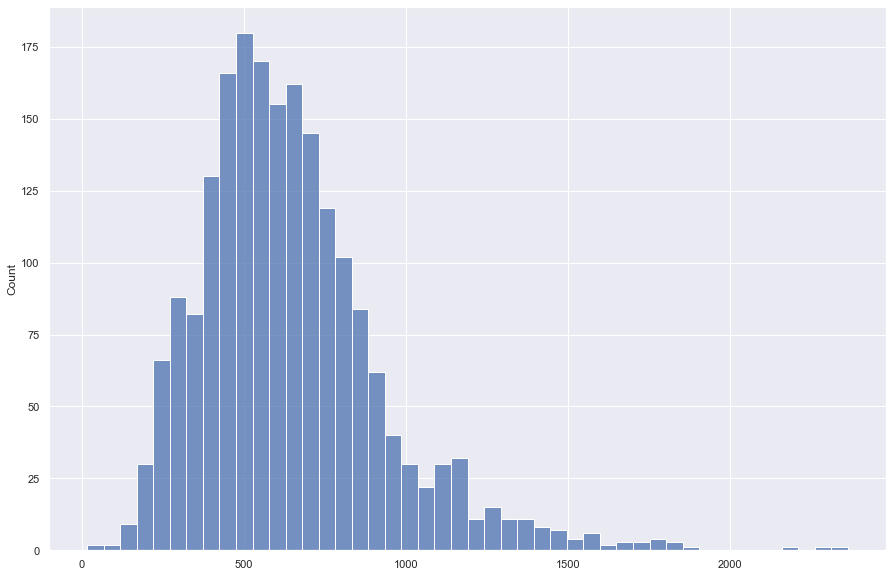

In [155]:
sns.set(rc={'figure.figsize':(15,10)})
sns.histplot(count)
plt.show()

vii. To represent each text (= data point), there are many ways. In NLP/Deep
Learning terminology, this task is called tokenization. It is common to rep-
resent text using popularity/ rank of words in text. The most common word
in the text will be represented as 1, the second most common word will be
represented as 2, etc. Tokenize each text document using this method.

In [231]:
reviews_list = df_reviews['review'].tolist()

In [232]:
L = int(np.percentile(count, 70))
L

737

In [233]:
reviews_train = df_train['review'].tolist()
reviews_test = df_test['review'].tolist()

In [234]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(reviews_train)

In [235]:
sequences_train = tokenizer.texts_to_sequences(reviews_train)
sequences_test = tokenizer.texts_to_sequences(reviews_test)

In [236]:
len(sequences_test)

600

ix. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L.

In [237]:
X_train = pad_sequences(sequences_train, maxlen=L, padding='post', truncating='post')
X_test = pad_sequences(sequences_test, maxlen=L, padding='post', truncating='post')
print(X_train.shape, X_test.shape)

(1400, 737) (600, 737)


(c) Word Embeddings

i. One can use tokenized text as inputs to a deep neural network. However, a recent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings. \Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning."4. Most deep learning modules (including Keras) provide a convenient way to convert positive integer representations of words into a word embedding by an \Embedding layer." The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the \output dimension." We would like to use a word embedding layer for this project. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document.5 If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 x L matrix.

ii. Flatten the matrix of each document to a vector.

(d) Multi-Layer Perceptron
i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of
20% for the first layer and 50% for the other layers. Use ADAM optimizer
and binary cross entropy loss (which is equivalent to having a softmax in the
output). To avoid overfitting, just set the number of epochs as 2. Use a batch
size of 10.

ii. Report the train and test accuracies of this model.

In [238]:
labels_train = np.array(df_train['label'].tolist())
labels_test = np.array(df_test['label'].tolist())

In [239]:
vocab_size = 5000
epochs = 2

In [240]:
model = Sequential()
model.add(Embedding(vocab_size, 32, input_length = L))
model.add(Flatten())
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 737, 32)           160000    
                                                                 
 flatten_6 (Flatten)         (None, 23584)             0         
                                                                 
 dense_24 (Dense)            (None, 50)                1179250   
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dropout_19 (Dropout)        (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 50)               

In [241]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [243]:
model.fit(X_train, labels_train, batch_size = 10, epochs = 2, verbose = 1, validation_data = (X_test, labels_test))

Epoch 1/2
140/140 [==============================] - 2s 12ms/step - loss: 0.0012 - accuracy: 0.9993 - val_loss: 2.0406 - val_accuracy: 0.6433
Epoch 2/2
140/140 [==============================] - 2s 12ms/step - loss: 9.7183e-04 - accuracy: 1.0000 - val_loss: 2.2743 - val_accuracy: 0.6383


In [247]:
score = model.evaluate(X_train, labels_train, verbose = 0)
print('Train Accuracy: ', score[1])

Train Accuracy:  1.0


In [246]:
score = model.evaluate(X_test, labels_test, verbose = 0)
print('Test Accuracy: ', score[1])

Test Accuracy:  0.6383333206176758


(e) One-Dimensional Convolutional Neural Network:
Although CNNs are mainly used for image data, they can also be applied to text
data, as text also has adjacency information. Keras supports one-dimensional
convolutions and pooling by the Conv1D and MaxPooling1D classes respectively.
i. After the embedding layer, insert a Conv1D layer. This convolutional layer
has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded
word representations 3 vector elements of the word embedding at a time. The
convolutional layer is followed by a 1D max pooling layer with a length and
stride of 2 that halves the size of the feature maps from the convolutional
layer. The rest of the network is the same as the neural network above.
ii. Report the train and test accuracies of this model.

In [251]:
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 32, input_length = L))
model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(50, activation = 'relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 737, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 735, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 367, 32)          0         
 )                                                               
                                                                 
 flatten_7 (Flatten)         (None, 11744)             0         
                                                                 
 dense_28 (Dense)            (None, 50)                587250    
                                                                 
 dropout_21 (Dropout)        (None, 50)                0         
                                                      

In [252]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [257]:
model_cnn.fit(X_train, labels_train, batch_size = 10, epochs = 2, verbose = 1, validation_data = (X_test, labels_test))

Epoch 1/2
140/140 [==============================] - 2s 16ms/step - loss: 0.0032 - accuracy: 0.9979 - val_loss: 2.9437 - val_accuracy: 0.7333
Epoch 2/2
140/140 [==============================] - 2s 12ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 1.9931 - val_accuracy: 0.7850


In [258]:
score = model_cnn.evaluate(X_train, labels_train, verbose = 0)
print('Train Accuracy: ', score[1])

Train Accuracy:  1.0


In [259]:
score = model_cnn.evaluate(X_test, labels_test, verbose = 0)
print('Test Accuracy: ', score[1])

Test Accuracy:  0.7850000262260437


(f) Long Short-Term Memory Recurrent Neural Network:
The structure of the LSTM we are going to use is shown in the following figure.
i. Each word is represented to LSTM as a vector of 32 elements and the LSTM
is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both
LSTM and the dense layer. Train the model using 10-50 epochs and batch
size of 10.

ii. Report the train and test accuracies of this model.

In [275]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 32, input_length = L))
model_lstm.add(LSTM(32, activation = 'relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 737, 32)           160000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_27 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 256)               8448      
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_39 (Dense)            (None, 1)                 257       
                                                                 
Total params: 177,025
Trainable params: 177,025
Non-t

In [276]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [277]:
model_lstm.fit(X_train, labels_train, batch_size = 10, epochs = 15, verbose = 1, validation_data = (X_test, labels_test))

Epoch 1/15
140/140 [==============================] - 21s 142ms/step - loss: 0.6930 - accuracy: 0.5064 - val_loss: 0.6901 - val_accuracy: 0.5400
Epoch 2/15
140/140 [==============================] - 17s 119ms/step - loss: nan - accuracy: 0.5186 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/15
140/140 [==============================] - 17s 121ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/15
140/140 [==============================] - 17s 125ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/15
140/140 [==============================] - 17s 123ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/15
140/140 [==============================] - 17s 123ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/15
140/140 [==============================] - 18s 126ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/15
140/140 [=

In [278]:
score = model_lstm.evaluate(X_train, labels_train, verbose = 0)
print('Train Accuracy: ', score[1])

Train Accuracy:  0.5


In [279]:
score = model_lstm.evaluate(X_test, labels_test, verbose = 0)
print('Test Accuracy: ', score[1])

Test Accuracy:  0.5
